## Config

In [96]:
import os
import re
import pandas as pd
import numpy as np
import random
import nltk
import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
from spacy.vocab import Vocab

from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import itertools
from itertools import chain

from platform import python_version
print("VERSION: ", python_version()) # expect 3.7.0

# dirty spaCy error workaround:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

VERSION:  3.7.0


In [2]:
os_path = '/Users/milk/Desktop/git/'
forms_dir = os_path + 'InformedConsentForms/data/all_forms'

In [3]:
nlp = spacy.load('en')
nlp_larg = spacy.load('en_core_web_lg')

## Semantic Clues

In [4]:
##  taken from: 
# “I found great synonyms for ‘permission’ on the new Thesaurus.com!,”
# www.thesaurus.com. [Online]. Available: https://www.thesaurus.com/browse/permission. 
## [Accessed: 19-Feb-2019].

permission_bases = ["permission", 
                    "authorization", 
                    "authorize",
                    "consent",
                    "assent",
                    "permit",
                    "approve",
                    "grant",
                    "allow",
                    "certify"]

## add synonyms

In [5]:
def addWordNetSynsets(word_list):
    " add synsets to new list "
    updated_list = []
    
    for word in word_list:
        updated_list.append(word)
        synonyms = wordnet.synsets(word, 'v')
        synonyms = set(chain.from_iterable([word.lemma_names() for word in synonyms]))
        
        [updated_list.append(x) for x in synonyms if x not in updated_list]
        
    return updated_list
        
permission_extended = addWordNetSynsets(permission_bases)
print('num elements:', len(permission_extended))
# [print(x) for x in permission_extended]

num elements: 51


## build consent form data structure
get dict and dataframe from each consent form on file

#### todo: get metadata

In [6]:
def getData(directory):
    """ returns a dict with cleaned filenames, full paths,
    and text data in multiple formats from a dictionary
    of .txt files"""
    
    fileDictionary = {}
    fileID = 0
    
    # iterate through directory
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            
            fileID += 1
            filepath = subdir + os.sep + file
            
            if filepath.endswith('.txt'):
                wordList = [] # this will include duplicates and stop words
                cleanedFileName = ''.join(e for e in file if e.isalnum())[:-3] 
                
                # perform string operations on each file
                with open(filepath, 'r') as myfile:
                    data = myfile.read().replace('\n', ' ')       
                
                fileDictionary[fileID] = {}
                fileDictionary[fileID]['name'] = cleanedFileName
                fileDictionary[fileID]['path'] = filepath
                fileDictionary[fileID]['rawText'] = data
    
    return fileDictionary

# run the function and store to variable 
consent_dictionary = getData(forms_dir)

# #test print statement
# [print(k,v, '\n') for k,v in consent_dictionary[1].items()]

In [7]:
def toDataFrame(fileDictionary):
    """ return pandas dataframe
    Note: expects input in nested dict format (output from getData)"""
    new_rows = []

    for key, value in fileDictionary.items():
        new_rows.append(value)
         
    df = pd.DataFrame(new_rows)
    return df

df = toDataFrame(consent_dictionary)

## Random sampling to develop
This will be removed when we want to process the whole corpus

In [8]:
# comment out to run on whole corpus
n_samples = 50
df = df.sample(n=n_samples)

## add spacy object to dataframe

#### WARNING: this takes a long time,

In [9]:
def getDocObjects(row, field):
    " return spacy doc object"
#     # small nlp library
#     doc = nlp(str(row[field]).lower())

    # large library
    doc = nlp_larg(str(row[field]).lower())
    return doc

df['docOB'] = df.apply(lambda row:getDocObjects(row, 'rawText'),axis=1)

In [10]:
df['docOB'].head()

333    (﻿this, model, clinical, research, consent, fo...
381    (vaccination, consent, form,  , king, ’s, daug...
144    (r*gencost*r,  , r, *,  , halifax, health,  , ...
120    (patient, i, d, sticker, mri, and, pregnancy, ...
347    (﻿important, :, all, sections, are, required, ...
Name: docOB, dtype: object

## extract sentences

In [11]:
def getSentenceList(row, field):
    " return list of sents from doc object"
    sent_list = []
    
    # must operate on a spaCy doc object 
    for sent in row[field].sents:
#         print(dir(sent))
        sent_list.append(sent)
    
    return sent_list

df['sentList'] = df.apply(lambda row:getSentenceList(row, 'docOB'),axis=1)

## preliminary permisison sentence extraction
look for sentences that have a word from the 'clues' list

# NOTE: DO WE WANT SENTENCE PAIRS? THREE SENTENCES?

In [14]:
def getPossiblePermissions(row, permissions_list):
    """ return list of sentences containing the 
    permissions words """
    
    sent_list = []
    
    for sent in row['sentList']:
        [sent_list.append(sent) for clue in\
             permission_extended if sent.text.__contains__(clue)]
                
    return sent_list

# here we only convert the first 10 rows to save time
df['permissionsStatements'] = df.apply(lambda row:getPossiblePermissions(row, permission_extended),axis=1)

In [15]:
for sent in df['permissionsStatements'][:10]:
    [print('sent:', x.text, '\n') for x in sent[:2]]

sent: ﻿this model clinical research consent form contains sample language. 

sent: the fhcrc irb recommends this sample language with the understanding that the authors of consent forms will edit the language to fit their studies. 

sent: vaccination consent form  king’s daughters medical center clinic  king’s daughters medical center (“kdmc”, “we” or “us”) will offer a series of vaccinations to the sixth-grade students at boyd county duiing the course of the 2016/2017school year. 

sent: the tdap vaccine is typically given in 1 dose (by shot). 

sent: consent to hospital care and release of information assignment of insurance benefits acceptance of financial responsibility  med. 

sent: consent to hospital care and release of information assignment of insurance benefits acceptance of financial responsibility  med. 

sent: however, according to the fda, the safety of mri procedures during pregnancy has not been definitively proven and not recommended except in extraordinary circumstanc

In [16]:
def getEstimatedPermissionDesnity(row):
    """ return proportion of sentence total that may
    be statements indicating perissions. Expect much noise. """
     
    return len(row['permissionsStatements'])/len(row['sentList'])
    
df['permissionDensity'] = df.apply(lambda row: getEstimatedPermissionDesnity(row),axis=1)

df.head(2)

,name,path,rawText,docOB,sentList,permissionsStatements,permissionDensity
333,ClinicalResearchConsentForm,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿This model clinical research consent form con...,"(﻿this, model, clinical, research, consent, fo...","[(﻿this, model, clinical, research, consent, f...","[(﻿this, model, clinical, research, consent, f...",0.321739
381,KingsDaughtersMedicalCenterClinic6thgradeph,/Users/milk/Desktop/git/InformedConsentForms/d...,VACCINATION CONSENT FORM King’s Daughters Med...,"(vaccination, consent, form, , king, ’s, daug...","[(vaccination, consent, form, , king, ’s, dau...","[(vaccination, consent, form, , king, ’s, dau...",0.163043


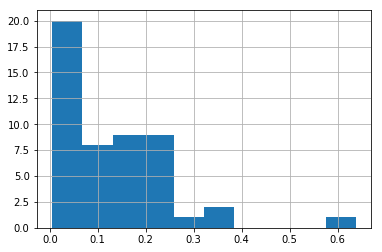

In [17]:
%matplotlib inline
df['permissionDensity'].hist()

## Important
this represents an important break away from the primary dataframe. here i start to work with list structures to create a list of possible permissions that is no longer tied to filenames

In [18]:
all_sents = []

for sentlist in df['sentList'].to_list():
    [all_sents.append(x) for x in sentlist]
    
all_permissions = []

for permlist in df['permissionsStatements'].to_list():
    [all_permissions.append(x) for x in permlist]

In [19]:
print('total rough draft permissions: ', len(all_permissions))
print('unique rough draft permissions: ', len(list(set(all_permissions))))

print('total rough draft sentences: ', len(all_sents))
print('unique rough draft sentences: ', len(list(set(all_sents))))

total rough draft permissions:  1475
unique rough draft permissions:  1133
total rough draft sentences:  15532
unique rough draft sentences:  15532


In [20]:
# remove duplucates
all_permissions = list(set(all_permissions))

## pair-wise similarity between our permission 'guesses' and remaining sentences
this is an important step so that we don't restrict ourselves to permission statements that contain the words we dreampt up

#### warning, this is not a good algorithm, will not scale

In [21]:
new_rows = []

for sent in all_sents:
    for perm in all_permissions:
        row = {
            'permission':perm,
            'sentence':sent,
            'similarity':sent.similarity(perm)
        }
        new_rows.append(row)

In [22]:
sf = pd.DataFrame(new_rows)
sf.head()

,permission,sentence,similarity
0,"(i, understand, and, accept, the, consequences...","(﻿this, model, clinical, research, consent, fo...",0.706578
1,"(you, will, be, provided, with, any, new, info...","(﻿this, model, clinical, research, consent, fo...",0.780099
2,"(the, following, statement, represents, what, ...","(﻿this, model, clinical, research, consent, fo...",0.725532
3,"(if, appropriate, ,, include, a, statement, in...","(﻿this, model, clinical, research, consent, fo...",0.800474
4,"(to, delete, these, shaded, boxes, ,, click, t...","(﻿this, model, clinical, research, consent, fo...",0.654948


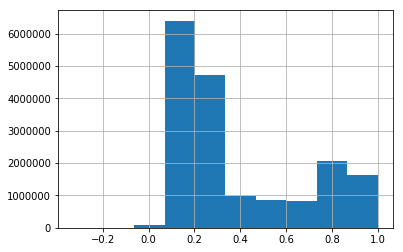

In [23]:
sf['similarity'].hist()

In [24]:
# reduce dataframe, aggregate by mean sim score (weak sents will balance out)
sf = sf.drop(columns=['permission'])
sf = sf.groupby(['sentence'], as_index=False).mean()

sf.head()

,sentence,similarity
0,"(﻿this, model, clinical, research, consent, fo...",0.736800
1,"(treatment, , to, , be, , preformed, , and...",0.873076
2,"(informed, consent, /, refusal, for, genetic, ...",0.706202
3,"(behave, wformed, choice, for, prelabor, ruptu...",0.787730
4,"(\t \t \t \t \t \t \t , consent, for, treatm...",0.857836


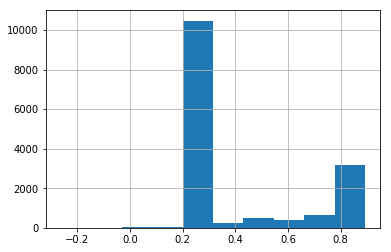

In [25]:
sf['similarity'].hist()

In [26]:
high_sim = sf[sf.similarity > .7]
candidates = high_sim['sentence'].to_list()

In [27]:
print('total rough draft candidates: ', len(candidates))
print('unique rough draft candidates: ', len(list(set(candidates))))

total rough draft candidates:  3702
unique rough draft candidates:  3702


In [28]:
[print('sent: ', x, '\n') for x in candidates[:10]]

sent:  ﻿this model clinical research consent form contains sample language. 

sent:  treatment to be preformed and general dentistry consent form    i understand that i am having the following treatment and acknowledge the important information below: 1)  

sent:  informed consent / refusal for genetic testing dna testing 1.   

sent:  behave wformed choice for prelabor rupture of membranes at term  what is it?   

sent:  	 	 	 	  	 	 	  consent for treatment as a patient of lifespan naturopathic medicine, you have the right to be informed about your health condition(s) and recommended treatment. 

sent:  dental clinic consent for endodontic treatment i understand root canal treatment is a procedure to retain a tooth, which may otherwise require extraction. 

sent:  informed consent for panel genetic testing fm104-7   

sent:  informat ional use only  nitrous oxide informed consent i hereby give permission for dr. 

sent:  ﻿ the ohio state university consent to participate in research 

[None, None, None, None, None, None, None, None, None, None]

In [29]:
rough_draft_permissions = all_permissions + candidates

In [30]:
print('total rough draft candidates: ', len(rough_draft_permissions))
print('unique rough draft candidates: ', len(list(set(rough_draft_permissions))))

total rough draft candidates:  4835
unique rough draft candidates:  3785


In [31]:
rough_draft_permissions = list(set(rough_draft_permissions))

## print statements to file

In [32]:
# import csv
# import datetime
# today = str(datetime.date.today())

# file_path = 'statements-'+today+'.csv'
# print(file_path)

# with open(file_path, 'a') as outcsv:   
#     #configure writer to write standard csv file
#     writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
#     writer.writerow(['raw_text', 'clean_text'])
#     for perm in rough_draft_permissions:
#         #Write item to outcsv
#         raw_text = perm.text
#         clean_text = re.sub('\s+', ' ', re.sub('\W+',' ',\
#                                re.sub('[^A-Za-z0-9]+',' ', \
#                                       re.sub(r'\d+', " ", raw_text)))).strip()
#         writer.writerow([raw_text, clean_text])

# Annotations?

This is the point where injecting further information via annotations may be a good idea. This then would require in import of another local file and a small methods section.

## matrix representations

a few different matrix representations of the permissions sentence

In [97]:
empty_doc = Doc(Vocab())


for perm in rough_draft_permissions[:10]:
    miniDocs = perm.as_doc()

['_', '__bytes__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__unicode__', '_bulk_merge', '_py_tokens', '_realloc', '_vector', '_vector_norm', 'cats', 'char_span', 'count_by', 'doc', 'ents', 'extend_tensor', 'from_array', 'from_bytes', 'from_disk', 'get_extension', 'get_lca_matrix', 'has_extension', 'has_vector', 'is_parsed', 'is_sentenced', 'is_tagged', 'mem', 'merge', 'noun_chunks', 'noun_chunks_iterator', 'print_tree', 'remove_extension', 'retokenize', 'sentiment', 'sents', 'set_extension', 'similarity', 'tensor', 'text', 'text_with_ws', 'to_array', 'to_bytes', 'to_disk', 'user_data', 'user_hooks', 'user_span_hooks', 'user_token_hooks', 'vector', 'vector_

In [90]:
permission_vectors = []

for perm in rough_draft_permissions:
#     print(perm.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])) # same features, different rows
#     print(perm.vector) # same shape
#     print(perm.vector_norm) # single value
#     print(perm.get_lca_matrix()) # differnt shapes
    permission_vectors.append(perm.vector)